<a href="https://colab.research.google.com/github/gbouzioto/chemical_polution/blob/main/notebooks/pollution_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statements

In [32]:
import os
from collections import OrderedDict
import numpy
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import zipfile

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import get_file
from tensorflow import expand_dims
from tensorflow.nn import softmax

## Load Dataset

In [2]:
project_dir = os.path.join('/', 'content')
dataset_file = os.path.join(project_dir, 'BlackSea.zip')
dataset_file_path = os.path.join(project_dir, 'BlackSea')

if not os.path.isdir(dataset_file_path):
    # download dataset if it does not exist
    url = 'http://dsfp.chem.uoa.gr/BlackSea/Predicted%20spatial%20distribution%20dataset.zip'
    urllib.request.urlretrieve(url, dataset_file)
    # extract images
    with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_file_path)

dataset_train = os.path.join(dataset_file_path, 'train')
dataset_prediction = os.path.join(dataset_file_path, 'prediction')

## Data Augmentation

### Train and Validation Generators

In [3]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [4]:
train_generator = train_datagen.flow_from_directory(
    dataset_train, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_train, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation')

Found 1126 images belonging to 3 classes.
Found 280 images belonging to 3 classes.


## InceptionV3

### Initialization and Summary

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add a dropout layer
x = Dropout(0.2)(x)
# and a logistic layer -- we have 3 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________

### Model Training

In [6]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=1126//32,
    epochs=5,
    validation_steps=280//32)

Epoch 1/5
35/35 [==============================] - 62s 793ms/step - loss: 1.1535 - accuracy: 0.7075 - val_loss: 0.4245 - val_accuracy: 0.8672
Epoch 2/5
35/35 [==============================] - 26s 752ms/step - loss: 0.3058 - accuracy: 0.9068 - val_loss: 0.2295 - val_accuracy: 0.9180
Epoch 3/5
35/35 [==============================] - 26s 754ms/step - loss: 0.2146 - accuracy: 0.9305 - val_loss: 0.1472 - val_accuracy: 0.9727
Epoch 4/5
35/35 [==============================] - 26s 755ms/step - loss: 0.1670 - accuracy: 0.9442 - val_loss: 0.1534 - val_accuracy: 0.9688
Epoch 5/5
35/35 [==============================] - 26s 751ms/step - loss: 0.1377 - accuracy: 0.9506 - val_loss: 0.1211 - val_accuracy: 0.9766


### Predicting Unknown Images

In [39]:
# Using the best model to predict unknown images and predict the pollution importance in the Black Sea
images = []
for img in os.listdir(dataset_prediction):
    img = os.path.join(dataset_prediction, img)
    img = image.load_img(img, target_size=(150, 150))
    img = image.img_to_array(img)
    img = numpy.expand_dims(img, axis=0)
    img = preprocess_input(img)
    images.append(img)

# stack up images list to pass for prediction
images = numpy.vstack(images)

In [40]:
predictions = model.predict(images)

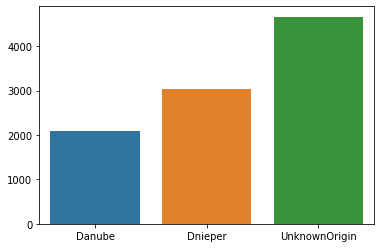

In [43]:
indeces = {value:key for (key,value) in train_generator.class_indices.items()}
distri = OrderedDict()
for item in predictions.argmax(axis=-1):
  if distri.get(indeces[item]):
    distri[indeces[item]] += 1
  else:
    distri[indeces[item]] = 1

sns.barplot(x=list(distri.keys()), y=list(distri.values()))